In [7]:
import pandas as pd
import re
import random
from psm_utils.psm import PSM
from psm_utils.psm_list import PSMList
from psm_utils.io import write_file
from pathlib import Path
import sys
import numpy as np
import pandas as pd

from deeplc import DeepLC

project_root = Path.cwd().parent

sys.path.append(str(project_root))

from make_predictions.intensity_predictions import obtain_predictions_pairs
from seq_utils.fasta_to_peptides import create_tryptic_peptides
from seq_utils.peptide import (
    remove_non_il,
    remove_ux_containing,
    switch_first_il,
    switch_random_il,
    has_il_outside_brackets,
    get_proforma_bracketed,
)
from metrics.get_metrics import metrics_comparison

from matplotlib import pyplot as plt

In [8]:
%matplotlib inline

In [9]:
fraction = 0.5
random_seed = 42

df = pd.read_csv("../temp_data/input_file.txt", sep="\t") # MQ search

parse_column = "Modified sequence"
before_aa = False
isalpha = True
isupper = True
pattern = "\\([^()]*\\)|\\([^()]*\\([^()]*\\)[^()]*\\)"
modification_dict = {"(ox)" : "Oxidation", "(ac)" : "Acetyl", "(oxidation (m))" : "Oxidation", "(acetyl (protein n-term))" : "Acetyl"}


df["proforma"] = df["Modified sequence"].apply(
    get_proforma_bracketed,
    before_aa=before_aa,
    isalpha=isalpha,
    isupper=isupper,
    pattern=pattern,
    modification_dict=modification_dict,
)

In [10]:
merged_df = df.merge(
    df.groupby("proforma")["Calibrated retention time"].mean(),
    on="proforma",
    how="left",
)
merged_df = merged_df.drop_duplicates(subset="proforma", keep="first")

In [11]:
df_train = merged_df.sample(frac=fraction, random_state=random_seed)
df_eval = merged_df.drop(df_train.index)

psm_list_train = []
psm_list_eval = []
psm_list_eval_swapped = []

for idx, row in df_train.iterrows():
    psm_list_train.append(
        PSM(
            peptidoform=row["proforma"],
            retention_time=row["Calibrated retention time_y"],
            spectrum_id=idx,

        )
    )

for idx, row in df_eval.iterrows():
    seq_swap = switch_random_il(row["proforma"])
    psm_list_eval.append(
        PSM(
            peptidoform=row["proforma"],
            retention_time=row["Calibrated retention time_y"],
            spectrum_id=idx,
        )
    )

    psm_list_eval_swapped.append(
        PSM(
            peptidoform=seq_swap,
            retention_time=row["Calibrated retention time_y"],
            spectrum_id=idx,
        )
    )


psm_list_train = PSMList(psm_list=psm_list_train)
psm_list_eval = PSMList(psm_list=psm_list_eval)
psm_list_eval_swapped = PSMList(psm_list=psm_list_eval_swapped)

In [12]:
dlc = DeepLC(
    deeplc_retrain=True,
    n_epochs=20,
)
dlc.calibrate_preds(
    psm_list_train
)


DeepLC tried to set intra op threads, but was unable to do so.


Epoch 1/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 16.2248 - mean_absolute_error: 16.2248 - val_loss: 4.5275 - val_mean_absolute_error: 4.5275
Epoch 2/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 3.5283 - mean_absolute_error: 3.5283 - val_loss: 3.1346 - val_mean_absolute_error: 3.1346
Epoch 3/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.9305 - mean_absolute_error: 2.9305 - val_loss: 3.0138 - val_mean_absolute_error: 3.0138
Epoch 4/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.9171 - mean_absolute_error: 2.9171 - val_loss: 2.9143 - val_mean_absolute_error: 2.9143
Epoch 5/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.7092 - mean_absolute_error: 2.7092 - val_loss: 2.8117 - val_mean_absolute_error: 2.8117
Epoch 6/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 2.6731 - mean_absolute_error: 2.6731 - val_loss: 2.7232 - val_mean_absolute_error: 2.7232
Epoch 7/20
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 2.6224 - mean_absolute_error: 2

{}

In [13]:
preds = dlc.make_preds(psm_list=psm_list_eval)
preds_swapped = dlc.make_preds(psm_list=psm_list_eval_swapped)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [14]:
df_eval["predicted_retention_time"] = preds
df_eval["predicted_retention_time_swapped"] = preds_swapped
df_eval["Calibrated retention time_y"]

10        113.115000
30        104.802000
50        128.795000
56         82.002200
61         53.505429
             ...    
267863    103.420000
267870     73.622714
267884     53.477286
267891    113.511667
267897    113.500000
Name: Calibrated retention time_y, Length: 22479, dtype: float64

In [15]:
# Compute absolute differences
diff_original = (df_eval["predicted_retention_time"] - df_eval["Calibrated retention time_y"]).abs()
diff_swapped = (df_eval["predicted_retention_time_swapped"] - df_eval["Calibrated retention time_y"]).abs()

# Compute the minimum error per row
min_error = np.minimum(abs(diff_original), abs(diff_swapped ))

# Sort the DataFrame by this minimum error
df_eval_sorted = df_eval.assign(min_error=min_error).sort_values("min_error").reset_index(drop=True)

# Create a column indicating which prediction is closer
df_eval_sorted["chosen_prediction_label"] = np.where(
    diff_original <= diff_swapped,
    "original",
    "swapped"
)

In [16]:
df_eval_sorted = df_eval_sorted[df_eval_sorted["proforma"].apply(has_il_outside_brackets)]

In [17]:
# Indicator columns
df_eval_sorted["is_original"] = (df_eval_sorted["chosen_prediction_label"] == "original").astype(int)
df_eval_sorted["is_swapped"] = (df_eval_sorted["chosen_prediction_label"] == "swapped").astype(int)

# Cumulative counts
df_eval_sorted["cum_original"] = df_eval_sorted["is_original"].cumsum()
df_eval_sorted["cum_swapped"] = df_eval_sorted["is_swapped"].cumsum()
df_eval_sorted["cum_total"] = df_eval_sorted["cum_original"] + df_eval_sorted["cum_swapped"]

# Compute cumulative fraction
df_eval_sorted["cum_fraction_original"] = df_eval_sorted["cum_original"] / df_eval_sorted["cum_total"]

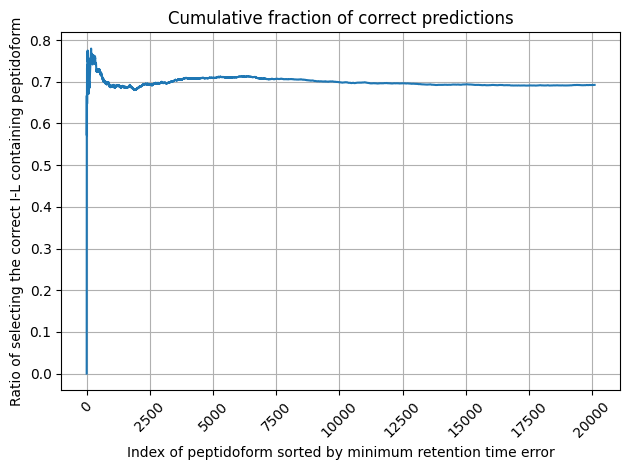

In [18]:
plt.plot(list(range(len(df_eval_sorted["cum_fraction_original"]))), df_eval_sorted["cum_fraction_original"])
plt.xlabel("Index of peptidoform sorted by minimum retention time error")
plt.ylabel("Ratio of selecting the correct I-L containing peptidoform")
plt.title("Cumulative fraction of correct predictions")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.savefig("figs/cumulative_fraction_correct_predictions.png")
plt.show()
plt.close()